In [15]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
# os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

import keras
import numpy as np
from keras.models import Model, load_model
from keras.layers import Dense, Input, Activation, Flatten, Add
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.datasets import cifar10
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from keras import backend
import matplotlib.pyplot as plt


In [2]:
(xx_train, yy_train), (x_test, y_test) = cifar10.load_data()
xx_train = xx_train.astype('float32')
x_test = x_test.astype('float32')

x_train = xx_train[:45000]
y_train = yy_train[:45000]
x_valid = xx_train[45000:50000]
y_valid = yy_train[45000:50000]

x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
y_test = np_utils.to_categorical(y_test)

In [3]:
x_train.shape[1:]

(32, 32, 3)

In [3]:
traingen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')
traingen.fit(x_train)

In [4]:
def add(a,b):
    shape1 = backend.int_shape(a)
    shape2 = backend.int_shape(b)
    w = int(round(shape1[1]/shape2[1]))
    h = int(round(shape1[2]/shape2[2]))
    eq = shape1[3] == shape2[3]
    
    tmp = a
    print w,h,eq
    print shape1, shape2
    if w>1 or h>1 or not eq:
        tmp = Conv2D(filters=shape2[3],kernel_size=(1,1),strides=(w,h),padding='valid',kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(a)
    print backend.int_shape(tmp)
    print
    return Add()([tmp, b])

### Modified ResNet v2

In [12]:
def layer(num_filt, size, strides, inp):
    tmp = BatchNormalization(axis=3)(inp)
    tmp = Activation('relu')(tmp)
    tmp = Conv2D(num_filt, size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(tmp)
    return tmp

l = Input(x_train.shape[1:])

x = Conv2D(128, (7,7), strides=2, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(l)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)

#first layer
num = 32
xtmp = Conv2D(num, (1,1), strides=1, 
              padding='same', 
              kernel_initializer='he_normal', 
              kernel_regularizer=l2(0.0001))(x)
xtmp = layer(num, (3,3), 1, xtmp)
xtmp = layer(num*4, (1,1), 1, xtmp)

x = add(x,xtmp)

#other layer
xtmp = layer(num, (1,1), 1, x)
xtmp = layer(num, (3,3), 1, xtmp)
xtmp = layer(num*4, (1,1), 1, xtmp)
x = add(x,xtmp)

for i in xrange(9):
    xtmp = layer(num, (1,1), 1, x)
    xtmp = layer(num, (3,3), 1, xtmp)
    xtmp = layer(num*4, (1,1), 1, xtmp)
    x = add(x,xtmp)

    #other layer
    xtmp = layer(num, (1,1), 1, x)
    xtmp = layer(num, (3,3), 1, xtmp)
    xtmp = layer(num*4, (1,1), 1, xtmp)
    x = add(x,xtmp)

x = BatchNormalization()(x)
x = Activation('relu')(x)

xshape = backend.int_shape(x)
x = AveragePooling2D(pool_size=(xshape[1],xshape[2]), strides=(1,1))(x)
x = Flatten()(x)

x = Dense(10, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(x)

early=EarlyStopping(monitor='val_acc', patience=15, verbose=1, mode='auto')
filepath="weights-with-augmentation.best.hdf5"
checkpoint=ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128)

1 1 True
(None, 16, 

In [13]:
model = Model(l,x)

model.compile(
    optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 16, 16, 128)  18944       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_123 (BatchN (None, 16, 16, 128)  512         conv2d_123[0][0]                 
__________________________________________________________________________________________________
activation_123 (Activation)     (None, 16, 16, 128)  0           batch_normalization_123[0][0]    
__________________________________________________________________________________________________
conv2d_124

In [6]:
#if training was cut short
model = load_model('weights.best.hdf5')

In [14]:
history = model.fit_generator(traingen.flow(x_train, y_train, batch_size=32),
                              steps_per_epoch=x_train.shape[0]//32, 
                              validation_data=(x_valid,y_valid),
                              epochs=200, 
                              verbose=1, 
                              max_queue_size=128,
                              shuffle=True,
                              callbacks=[checkpoint, early, lr_reducer])

Epoch 1/200
1406/1406 [==============================] - 5471s 4s/step - loss: 2.1331 - acc: 0.3862 - val_loss: 2.0329 - val_acc: 0.3986
Epoch 2/200
1406/1406 [==============================] - 1551s 1s/step - loss: 1.7271 - acc: 0.4858 - val_loss: 2.1599 - val_acc: 0.4518
Epoch 3/200
1406/1406 [==============================] - 1529s 1s/step - loss: 1.5692 - acc: 0.5238 - val_loss: 1.7589 - val_acc: 0.4892
Epoch 4/200
1406/1406 [==============================] - 1539s 1s/step - loss: 1.4686 - acc: 0.5545 - val_loss: 1.9538 - val_acc: 0.4444
Epoch 5/200
1406/1406 [==============================] - 1554s 1s/step - loss: 1.3961 - acc: 0.5765 - val_loss: 1.6535 - val_acc: 0.5328
Epoch 6/200
1406/1406 [==============================] - 1544s 1s/step - loss: 1.3397 - acc: 0.5971 - val_loss: 1.6553 - val_acc: 0.4994
Epoch 7/200
1406/1406 [==============================] - 1534s 1s/step - loss: 1.2986 - acc: 0.6103 - val_loss: 1.4312 - val_acc: 0.5948
Epoch 8/200
1406/1406 [==================

Epoch 30/200
1406/1406 [==============================] - 1521s 1s/step - loss: 0.9671 - acc: 0.7407 - val_loss: 1.0630 - val_acc: 0.7348
Epoch 31/200
1406/1406 [==============================] - 1523s 1s/step - loss: 0.9580 - acc: 0.7425 - val_loss: 1.1879 - val_acc: 0.6992
Epoch 32/200
1406/1406 [==============================] - 1557s 1s/step - loss: 0.9537 - acc: 0.7423 - val_loss: 0.9183 - val_acc: 0.7644
Epoch 33/200
1406/1406 [==============================] - 1541s 1s/step - loss: 0.9487 - acc: 0.7462 - val_loss: 1.2936 - val_acc: 0.6798
Epoch 34/200
1406/1406 [==============================] - 1539s 1s/step - loss: 0.8354 - acc: 0.7844 - val_loss: 0.6612 - val_acc: 0.8466
Epoch 35/200
1406/1406 [==============================] - 1527s 1s/step - loss: 0.8051 - acc: 0.7935 - val_loss: 0.6641 - val_acc: 0.8468
Epoch 36/200
1406/1406 [==============================] - 1522s 1s/step - loss: 0.7816 - acc: 0.8001 - val_loss: 0.6966 - val_acc: 0.8356
Epoch 37/200
1406/1406 [==========

Epoch 60/200
1406/1406 [==============================] - 1545s 1s/step - loss: 0.6132 - acc: 0.8460 - val_loss: 0.5392 - val_acc: 0.8770
Epoch 61/200
1406/1406 [==============================] - 1555s 1s/step - loss: 0.6123 - acc: 0.8452 - val_loss: 0.5473 - val_acc: 0.8706
Epoch 62/200
1406/1406 [==============================] - 1547s 1s/step - loss: 0.6088 - acc: 0.8469 - val_loss: 0.5410 - val_acc: 0.8742
Epoch 63/200
1406/1406 [==============================] - 1528s 1s/step - loss: 0.6106 - acc: 0.8470 - val_loss: 0.5265 - val_acc: 0.8780
Epoch 64/200
1406/1406 [==============================] - 1529s 1s/step - loss: 0.6050 - acc: 0.8460 - val_loss: 0.5333 - val_acc: 0.8724
Epoch 65/200
1406/1406 [==============================] - 1523s 1s/step - loss: 0.6022 - acc: 0.8469 - val_loss: 0.5192 - val_acc: 0.8786
Epoch 66/200
1406/1406 [==============================] - 1521s 1s/step - loss: 0.6004 - acc: 0.8485 - val_loss: 0.5376 - val_acc: 0.8758
Epoch 00066: early stopping


### Result after stopping at 66 epochs

In [16]:
res = model.evaluate(x_test, y_test, batch_size=512)
print('Loss: %.2f Accuracy: %.2f%%' % (res[0], res[1]*100.0))

10000/10000 [==============================] - 115s 12ms/step
Loss: 0.55 Accuracy: 87.25%


### Best result of 60 epochs

In [12]:
model2 = load_model('weights.best.hdf5')
res = model2.evaluate(x_test, y_test, batch_size=512)
print('Loss: %.2f Accuracy: %.2f%%' % (res[0], res[1]*100.0))

10000/10000 [==============================] - 142s 14ms/step
Loss: 0.98 Accuracy: 80.06%


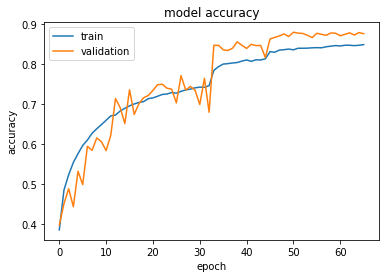

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

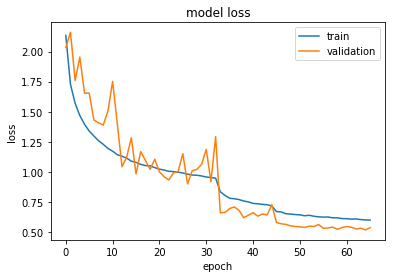

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()